In [1]:
import seaborn as sns
import matplotlib.pyplot as plt
import src.measurements.api as mpi
import numpy as np

In [2]:
dates = mpi.unique_dates()
measurement = mpi.measurement(dates)

In [3]:
len(dates)  # Number of unique Measurements

1246

In [4]:
measurement.describe()

,datetime,energy,count
count,10167360,1.016736e+07,1.016736e+07
mean,2021-06-12 03:57:33.639648256,1.407263e+03,2.352156e+02
min,2016-11-21 09:27:54,-1.140000e+00,0.000000e+00
25%,2020-09-15 07:12:43,7.028000e+02,0.000000e+00
50%,2021-08-05 11:56:36.500000,1.406300e+03,1.000000e+00
75%,2022-11-11 06:45:42,2.109590e+03,6.000000e+00
max,2024-10-02 07:37:57,2.987800e+03,1.127511e+07
std,NaN,8.140717e+02,1.481372e+04


In [5]:
measurement.describe().apply(lambda s: s.apply("{0:.5f}".format))

,datetime,energy,count
count,10167360.00000,10167360.00000,10167360.00000
mean,.5f,1407.26332,235.21555
min,.5f,-1.14000,0.00000
25%,.5f,702.80000,0.00000
50%,.5f,1406.30000,1.00000
75%,.5f,2109.59000,6.00000
max,.5f,2987.80000,11275109.00000
std,nan,814.07168,14813.72115


In [6]:
measurement_diffs = (
    measurement.sort_values(by="energy").groupby("datetime").diff().dropna()
)
measurement_diffs["energy"] = measurement_diffs["energy"].round(2)
measurement_diffs = measurement_diffs.join(
    measurement, lsuffix="_diffs", rsuffix="_raw", how="left"
)
diffs = measurement_diffs.groupby("energy_diffs").count().reset_index()
diffs["percent"] = diffs["count_diffs"] / diffs["count_diffs"].sum() * 100

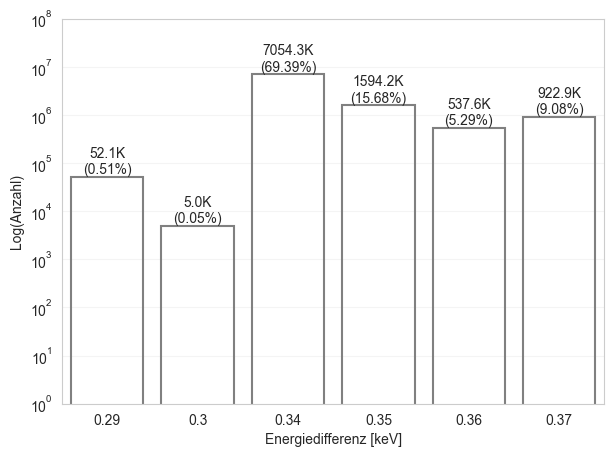

In [7]:
"""
Plotting the differences of the energies, to analyse the x-axis for every measurement.
"""
plt.rcParams["svg.fonttype"] = "none"
fig = plt.figure(figsize=(7, 5))
ax = sns.barplot(
    diffs,
    x="energy_diffs",
    y="count_diffs",
    color="grey",
    linewidth=1.5,
    edgecolor=".5",
    facecolor=(0, 0, 0, 0),
)
labels = [
    f"{c / 1e3:.1f}K\n({p:.2f}%)"
    for c, p in zip(diffs["count_diffs"], diffs["percent"])
]
ax.bar_label(ax.containers[0], labels=labels, fontsize=10)
# plt.title("Untersuchung der Energiewerte")
plt.xlabel("Energiedifferenz [keV]")
plt.ylabel("Log(Anzahl)")
plt.grid(axis="y", alpha=0.2)
plt.yscale("log")
plt.ylim(1, 100000000)
plt.savefig("plots\\energy_diffs.svg")
plt.show()
plt.close()

In [8]:
measurement = measurement.sort_values(by="count")
measurement["count_shifted"] = measurement["count"] + 1
counts = measurement["count"].to_numpy() + 1
print(counts)

log_counts = np.log(counts)
sigma = np.std(log_counts)
mu = np.mean(log_counts)

x = np.linspace(min(counts), max(counts), 10000000)
pdf = np.exp(-((np.log(x) - mu) ** 2) / (2 * sigma**2)) / (
    x * sigma * np.sqrt(2 * np.pi)
)

[       1        1        1 ... 10160756 10512824 11275110]


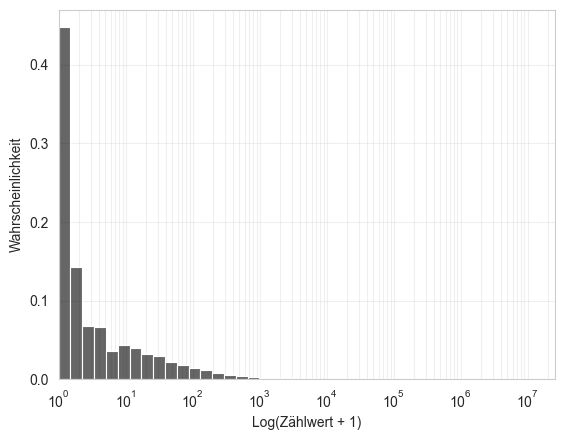

In [9]:
sns.histplot(
    counts,
    bins=40,
    stat="probability",
    color="black",
    alpha=0.6,
    label="Data",
    log_scale=(True, False),
)
# plt.hist(counts, 20, density=True, align='mid')
plt.xlabel("Log(Zählwert + 1)")
# plt.xscale("log")
plt.ylabel("Wahrscheinlichkeit")
plt.grid(True, alpha=0.3, which="both")
plt.xlim(
    1,
)
plt.savefig("plots\\count_histogram.svg")
plt.show()
plt.close()

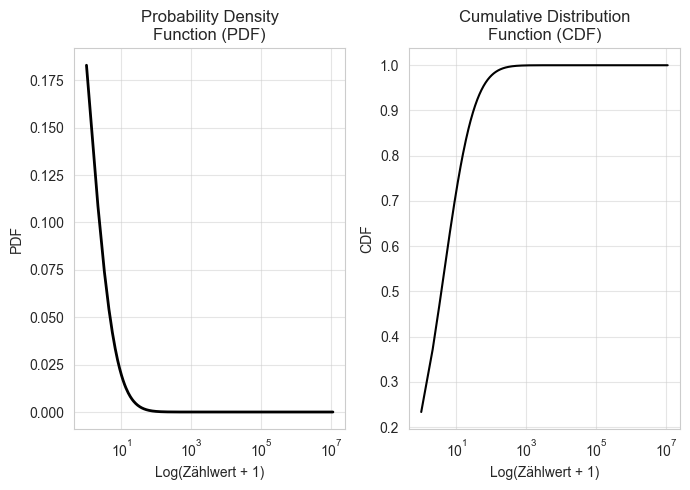

In [10]:
dx = x[1] - x[0]  # step size
cdf = np.cumsum(pdf) * dx
cdf /= cdf[-1]

fig, axs = plt.subplots(1, 2, figsize=(7, 5))

axs[0].plot(x, pdf, color="black", linewidth=2)
axs[0].set_xscale("log")
axs[0].set_xlabel("Log(Zählwert + 1)")
axs[0].set_ylabel("PDF")
axs[0].grid(True, alpha=0.5, which="both")
axs[0].set_title("Probability Density\nFunction (PDF)")

axs[1].plot(x, cdf, color="black")
axs[1].set_xscale("log")
axs[1].set_xlabel("Log(Zählwert + 1)")
axs[1].set_ylabel("CDF")
axs[1].grid(True, alpha=0.5, which="both")
axs[1].set_title("Cumulative Distribution\nFunction (CDF)")

fig.tight_layout()
plt.savefig("plots\\count_cdf.svg")

plt.show()

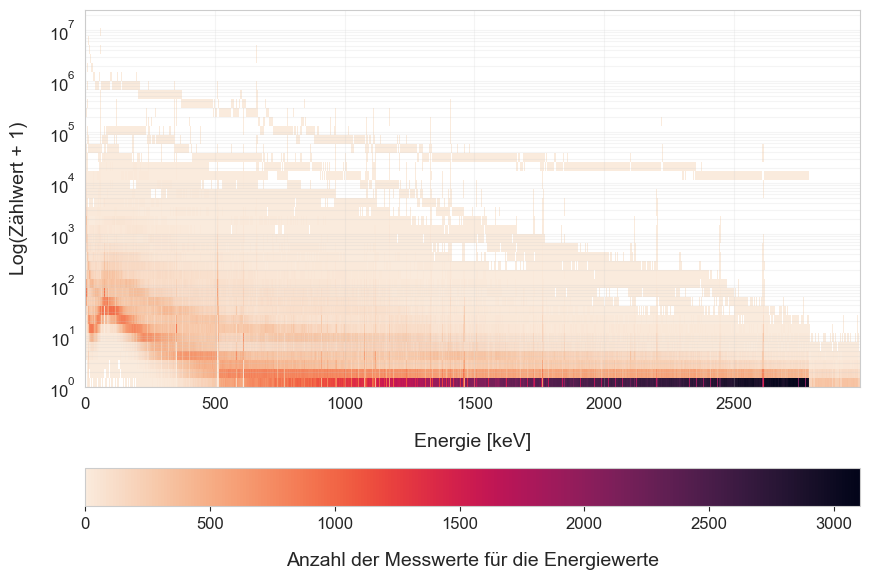

In [11]:
plt.figure(figsize=(10, 7))
measurement["count_shifted"] = measurement["count"] + 1
ax = sns.histplot(
    measurement,
    x="energy",
    y="count_shifted",
    bins=(2988, 40),
    log_scale=(False, True),
    cbar=True,
    cbar_kws={
        "orientation": "horizontal",
        "shrink": 1,
        "label": "Anzahl der Messwerte für die Energiewerte",
    },
    cmap=sns.color_palette("rocket_r", as_cmap=True),
    zorder=-10,
    # rasterized=True
)
cbar = ax.figure.axes[-1]
cbar.xaxis.label.set_size(14)
cbar.xaxis.labelpad = 15
cbar.tick_params(labelsize=12)
ax.set_rasterization_zorder(0)
plt.xlabel("Energie [keV]", size=14, labelpad=15)
plt.ylabel("Log(Zählwert + 1)", size=14, labelpad=15)
plt.xticks(size=12)
plt.yticks(size=12)
plt.ylim(1)
plt.xlim(0, 2988)
plt.grid(alpha=0.2, which="both")
plt.savefig("plots\\count_energy_heatmap.svg", format="svg")
plt.show()

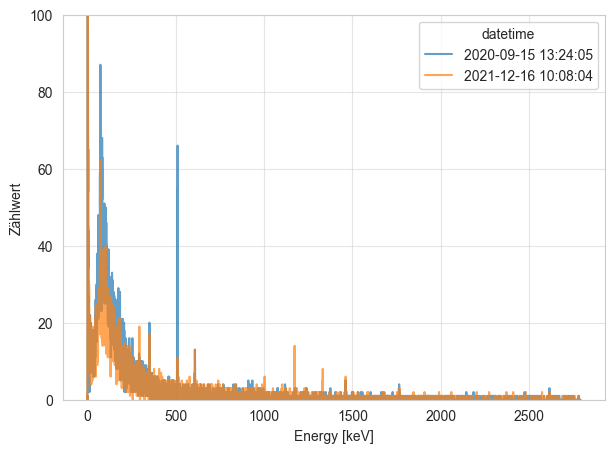

In [12]:
one_measurement = measurement.loc[measurement["datetime"].isin(dates[6:8])]

plt.figure(figsize=(7, 5))
sns.lineplot(one_measurement, x="energy", y="count", hue="datetime", alpha=0.7)

plt.ylim(0, 100)
plt.xlabel("Energy [keV]")
plt.ylabel("Zählwert")
plt.grid(alpha=0.5)
plt.savefig("plots\\measurement_example.svg")
plt.show()

In [13]:
measurement_diffs.describe().apply(lambda s: s.apply("{0:.5f}".format))

,energy_diffs,count_diffs,datetime,energy_raw,count_raw
count,10166114.00000,10166114.00000,10166114.00000,10166114.00000,10166114.00000
mean,0.34507,0.00082,.5f,1407.43586,235.24397
min,0.29000,-2399460.00000,.5f,-0.78000,0.00000
25%,0.34000,-1.00000,.5f,703.15000,0.00000
50%,0.34000,0.00000,.5f,1406.30000,1.00000
75%,0.35000,1.00000,.5f,2109.80000,6.00000
max,0.37000,2667689.00000,.5f,2987.80000,11275109.00000
std,0.01032,2276.21540,nan,813.97237,14814.62871


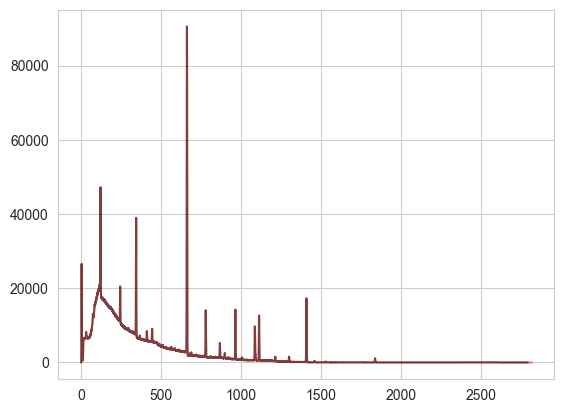

0.34507313512321336


In [14]:
import numpy as np
from scipy.interpolate import interp1d


def interpolate_spectrum(energy_original, counts_original, energy_target):
    f = interp1d(
        energy_original,
        counts_original,
        kind="nearest",
        bounds_error=False,
        fill_value=0,
    )
    return f(energy_target)


step_size = measurement_diffs["energy_diffs"].mean()
energy_max = step_size * 8160
# etwas über 2987.8, MAX VALUE OF diffs
energy_axis = np.arange(0, energy_max, step_size)
test_energy = measurement.loc[measurement["datetime"] == dates[0]].sort_values(
    by="energy"
)
interpolated_counts = interpolate_spectrum(
    test_energy["energy"].values, test_energy["count"].values, energy_axis
)

test_energy["energy_axis"] = energy_axis
test_energy["interpolated_counts"] = interpolated_counts

plt.plot(energy_axis, interpolated_counts, color="red", alpha=0.5)
plt.plot(test_energy["energy"], test_energy["count"], alpha=0.5, color="black")
# plt.xlim(0, 10)
plt.show()

print(step_size)